# Goal

This notebook contains much of the code for preprocessing and model fitting for the new estimators for this project.

More specifically, this notebook has a few goals 
1. Train a propensity model for every player (probability of presence on court)
2. Train models that will predict a target given exposure (presence) and unexposure (absence)
3. Use the above models to produce metrics for every player

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from nba_api.stats.endpoints import CommonAllPlayers 
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.spatial.distance import mahalanobis
from typing import Callable
from dataclasses import dataclass

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 75)

c:\Users\Daniel\.virtualenvs\rapm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparing the Data

Before we can begin model training (or any statistics), we need to prepare the data.

Much of this section is preprocessing. While it makes most sense to include this in a 
separate notebook, it was easiest to do it here since I frequently refer to each of the variables.

In [2]:
data: pd.DataFrame             = pd.read_csv('../../data/nba_2223_season_stints.csv', dtype={'game_id': str})
plr_id_to_name: dict[str, str] = pd.read_csv('../../data/nba_2223_player_table.csv', index_col='player_id', dtype={'player_id': str})['player_name'].to_dict()
plr_name_to_id: dict[str, str] = dict((v,k) for k,v in plr_id_to_name.items())
box_scores: pd.DataFrame       = pd.read_csv('../../data/nba_2223_box_stats.csv')
per36_stats: pd.DataFrame      = pd.read_csv('../../data/nba_2223_per36_stats.csv')
design: pd.DataFrame           = pd.read_csv('../../design_matrices/nba_2223_season_rapm_data.csv.gz') \
                                   .drop(['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin'], axis=1)

First we handle the box score data. We remove accents from player names, add their IDs, and save it.

In [3]:
import unicodedata

def strip_accents(s):
   '''
   Credit to https://stackoverflow.com/a/518232
   '''
   return ''.join(c for c in unicodedata.normalize('NFD', s) 
                  if unicodedata.category(c) != 'Mn')

box_scores['Player']   = box_scores['Player'].apply(strip_accents)
box_scores['PlayerID'] = box_scores['Player'].apply(lambda name: plr_name_to_id[name])

Some players have multiple entries (different teams, different positions, etc). We pool all their data and take the total statistics.

Also merge per 36 minute statistics.

In [4]:
cols_to_keep = per36_stats.columns.difference(box_scores.columns)
box_scores = pd.merge(box_scores, per36_stats[cols_to_keep], left_index=True, right_index=True)

box_scores.drop_duplicates('Player', keep='first', inplace=True) # total is always first
box_scores.reset_index(drop=True, inplace=True)
box_scores.set_index('PlayerID', inplace=True)

The models depend on the strength of each team. We infer the strength of home and away.

Strength is defined as the sum of each player's Ball Per Minute (BPM) score.

In [5]:
# careful with the axes. the player IDs are sorted lexicographically, not numerically
home_indicators = design.replace(-1, 0).sort_index(axis=1)
away_indicators = design.replace(1, 0).mul(-1).sort_index(axis=1)
bpm             = box_scores.sort_values('PlayerID')['BPM'].astype(float).to_numpy()

data['home_strength'] = home_indicators.mul(bpm, axis=1).sum(axis=1)
data['away_strength'] = away_indicators.mul(bpm, axis=1).sum(axis=1)

Now we infer game information. We also filter out stints where the game is decided.

In [6]:
def add_game_features(season_data: pd.DataFrame) -> pd.DataFrame:
    '''
    Given a processed season's data, add features for each stint
    relating to game. Specifically, this adds:

      `pm`                  : Plus minus of the stint (Home - Away).
      `home_score`          : The score of the home team.
      `away_score`          : The score of the away team.
      `end_score_margin`    : The score margin at the end of the stint (Home - Away).
      `start_score_margin`  : The score margin at the start of the stint (Home - Away).
      `start_time_left`     : Time left at the start of the stint.
      `end_time_left`       : Time left at the end of the stint

    Note that `score_margin` and `time_left` may be 
    inaccurate by a few points/minutes for later
    stints due to missing data. This is beyond my control.
    '''
    games = pd.unique(season_data['game_id'])

    list_of_data = []
    for game_id in games:
        game_data: pd.DataFrame = season_data[season_data['game_id'] == game_id]
        game_data['pm']         = game_data['home_points'] - game_data['away_points']

        game_data['home_score']         = game_data['home_points'].cumsum()
        game_data['away_score']         = game_data['away_points'].cumsum()
        game_data['end_score_margin']   = game_data['home_score'] - game_data['away_score']
        game_data['start_score_margin'] = game_data['end_score_margin'].shift(fill_value=0)

        # this is not exactly "time remaining" 
        # since some games have missing stints
        # it's a decent approximation though
        time_elapsed = game_data['minutes'].cumsum()
        game_data['start_time_left'] = 48 - time_elapsed.shift(fill_value=0)
        game_data['end_time_left']   = 48 - time_elapsed
    
        list_of_data.append(game_data)

    return pd.concat(list_of_data)

In [7]:
data = add_game_features(data)

# filter out stints when the game is decided
# drop iff start_time_elapsed >= 36 AND |start_score_margin| >= 20
# keep iff start_time_elapsed < 36 OR |start_score_margin| < 20
ok_stints = (data['start_time_left'] < 36) | (data['start_score_margin'].abs() < 20)
data = data[ok_stints]
design = design[ok_stints]

C:\Users\Daniel\AppData\Local\Temp\ipykernel_22252\3247247044.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['pm']         = game_data['home_points'] - game_data['away_points']
C:\Users\Daniel\AppData\Local\Temp\ipykernel_22252\3247247044.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['home_score']         = game_data['home_points'].cumsum()
C:\Users\Daniel\AppData\Local\Temp\ipykernel_22252\3247247044.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Finally, infer the total minutes played for each player (done at the end in order to exclude filtered stints)

In [8]:
box_scores['Min'] = np.empty(len(box_scores))
for plr_id in box_scores.index:
    box_scores.at[plr_id, 'Min'] = data['minutes'].mul(design[plr_id].abs()).sum()

def get_low_min_plrs(plr_data: pd.DataFrame, *, thresh: float = 48) -> pd.Index:
    '''
    Return every player whose minutes are below a threshold.

    In the given dataset, the index is expected to be the PlayerID.
    '''
    return plr_data[plr_data['Min'] < thresh].index

# Fit the Player Models

All the preprocessing is complete. At this point, we must fit models for every player. The propensity model will be a Random Forest, while the margin models Ridge Regression.

Every player must be trained on stints where they *could* have been present, so filtering the data for each player is necessary. 
Since players can be apart of multiple teams, it is complicated to determine games they could've been a part of, as this requires determining
when the player swapped teams. **As such, the model is only trained on stints in a game where the player was on the court at least once.**

Note that we require each players' total play time to be at least 48 minutes (1 full game). Otherwise, they will not be given a metric or a model. They are not dropped from the dataset in total. (The alternative requires us to drop stints they were present in due to how "strength" and "closeness" is determined.)

In [9]:
# it's necessary to determine games where the player was present at least once
#
# moreover, it's necessary to determine whether the player was on home/away,
# in order to appropriately adjust score margin.
#
# this solution basically replaces the design matrix. instead of being an indicator
# for presence in the stint, it will serve for an indicator of presence in the game.

games = pd.unique(data['game_id'])

plr_indicators_list = []
for game_id in games:
    indicators: pd.DataFrame = design[data['game_id'] == game_id]

    sign = np.sign(indicators.sum(axis=0))

    plr_indicators_list.append(
        indicators.replace(0, {
            plr_id: indic
            for plr_id, indic in zip(indicators.columns, sign)
            if indic != 0
        })
    )

game_presence = pd.concat(plr_indicators_list)

In [10]:
game_presence.head(50)

201939  202691  203110  203952  1626172  1629673  203210  1630164  \
0        1       1       1       1        1        1       1        1   
1        1       1       1       1        1        1       1        1   
2        1       1       1       1        1        1       1        1   
3        1       1       1       1        1        1       1        1   
4        1       1       1       1        1        1       1        1   
5        1       1       1       1        1        1       1        1   
6        1       1       1       1        1        1       1        1   
7        1       1       1       1        1        1       1        1   
8        1       1       1       1        1        1       1        1   
9        1       1       1       1        1        1       1        1   
10       1       1       1       1        1        1       1        1   
11       1       1       1       1        1        1       1        1   
12       1       1       1       1        1        1       1        1   
13       1       1       1       1        1        1       1        1   
14       1       1       1       1        1        1       1        1   
15       1       1       1       1        1        1       1        1   
16       1       1       1       1        1        1       1        1   
17       1       1       1       1        1        1       1        1   
18       1       1       1       1        1        1       1        1   
19       1       1       1       1        1        1       1        1   
20       1       1       1       1        1        1       1        1   
21       1       1       1       1        1        1       1        1   
22       1       1       1       1        1        1       1        1   
23       1       1       1       1        1        1       1        1   
24       1       1       1       1        1        1       1        1   
25       1       1       1       1        1        1       1        1   
26       1       1       1       1        1        1       1        1   
27       1       1       1       1        1        1       1        1   
28       1       1       1       1        1        1       1        1   
29       1       1       1       1        1        1       1        1   
30       1       1       1       1        1        1       1        1   
31       1       1       1       1        1        1       1        1   
32       1       1       1       1        1        1       1        1   
33       1       1       1       1        1        1       1        1   
34       0       0       0       0        0        0       0        0   
35       0       0       0       0        0        0       0        0   
36       0       0       0       0        0        0       0        0   
37       0       0       0       0        0        0       0        0   
38       0       0       0       0        0        0       0        0   
39       0       0       0       0        0        0       0        0   
40       0       0       0       0        0        0       0        0   
41       0       0       0       0        0        0       0        0   
42       0       0       0       0        0        0       0        0   
43       0       0       0       0        0        0       0        0   
44       0       0       0       0        0        0       0        0   
45       0       0       0       0        0        0       0        0   
46       0       0       0       0        0        0       0        0   
47       0       0       0       0        0        0       0        0   
48       0       0       0       0        0        0       0        0   
49       0       0       0       0        0        0       0        0   

    1630228  1628978  1630541  1631157  201143  203935  1627759  1628369  \
0         1        1        1        1       0       0        0        0   
1         1        1        1        1       0       0        0        0   
2         1        1        1        1       0      

For both the propensity and margin models, we will need to evaluate the player team's strength.

However, this has an issue: sometimes the player is present, other times the player isn't.
- If the player is present, we can just use the other 4 players.
- If the player isn't present, we will have to remove the "closest player"

In the 2nd case, we will determine closeness based on the Mahalonabis distance of the features "POS", "2PA", "3PA", "FTA", "TRB", "AST", "STL", "BLK"

POS will be handled like so:
 - If there is exactly 1 player on court with the same position, consider them closest.
 - If there are none or more, consider Mahalonabis distance for everyone.

In [11]:
DISTANCE_FEATURES = ["2PA", "3PA", "FTA", "TRB", "AST", "STL", "BLK"]
inv_cov = np.linalg.inv(box_scores[DISTANCE_FEATURES].cov())

def determine_closest_player(ref_plr_id: str, plr_list: list[str], *, inv_cov: np.ndarray = inv_cov) -> str:
    '''
    Determine the closest player to the reference player.
    
    If there is only one player whose position is the same
    as the reference player, then this player is returned instead.

    By default, the pre-computed inverse covariance is used. 
    Pass in a different one if this needs to be changed.
    '''
    closest_plr, closest_val = None, np.inf
    same_pos_plr, count = None, 0

    ref_features  = box_scores.loc[ref_plr_id, DISTANCE_FEATURES]
    ref_positions = box_scores.at[ref_plr_id, 'Pos'].split('-')

    for plr_id in plr_list:
        for pos in ref_positions:
            if pos in box_scores.at[plr_id, 'Pos']:
                same_pos_plr = plr_id
                count += 1

        dist = mahalanobis(ref_features, box_scores.loc[plr_id, DISTANCE_FEATURES], VI=inv_cov)
        if dist < closest_val:
            closest_val = dist
            closest_plr = plr_id
    
    return same_pos_plr if count == 1 else closest_plr


In [12]:
import json

# computing the "most alike player" is expensive, so it's cached into a json file
with open('sub_cache.json') as file:
    substitution_cache: dict[str, list[float]] = json.load(file)

def export_cache(sub_dict: dict[str, pd.Series]):
    new_cache = {
        plr: series.to_list()
        for plr, series in sub_dict.items()
    }

    with open('sub_cache.json', 'w') as fp:
        json.dump(new_cache, fp)

def get_features(df: pd.DataFrame, /) -> pd.DataFrame:
  '''
  Return the features used to train the models.

  This is purely for readability.
  '''
  return df[['start_score_margin', 'team_strength', 'opponent_strength']]

def _apply_substitution(row: pd.Series, *, ref_plr: str) -> float:
    '''
    Determines the BPM of the player that will be "substituted"

    To be applied in the 'train' functions.
    '''
    team = 'home' if row['_indicator'] == 1 else 'away'
    return box_scores.at[
       determine_closest_player(ref_plr, row[f'{team}_lineup'].split('_')), 
       'BPM'
    ]

In [67]:
@dataclass(kw_only=True)
class PlayerPropensityModel:
    '''
    A dataclass container for the propensity model.

    ## Attributes
      `plr_id`: The ID of the player.
      `model`: The propensity model.
      `data`: The data used to train the model.
      `targets`: The targets of the corresponding data.
    '''
    plr_id: str
    model: RandomForestClassifier
    data: pd.DataFrame
    target: pd.Series

def train_prop_model(
        plr_id: str, 
        *, 
        bpm_cache: dict[str, list[float]] = substitution_cache,
        season_presence: pd.DataFrame = game_presence, 
        season_design: pd.DataFrame   = design, 
        season_data: pd.DataFrame     = data
    ) -> PlayerPropensityModel:
    '''
    Given a player ID, train a propensity model. 
    This is trained on the features `['start_score_margin', 'team_strength', 'opponent_strength']` in that order.
    All stints are weighted by their number of possessions.

    ## Parameters

      `plr_id`: The player to train the model on.

      `cache`: A cache containing the substituted BPM values for every player.
      This is a rather costly operation, so it's preferred to save this cache.
      This is the global variable `substitution_cache` by default.

      `season_presence` : Indicators for presence in a game.
      Namely: 1 if player was present on Home, -1 if present on away, 0 if absent.
      This marks games containing stints the player could have been in.
      This is the global variable `game_precense` by default.
      
      `season_design`   : Indicators for presence in a stint. Standard RAPM design matrix.
      This is the global variable `design` by default.

      `season_data`     : Processed season data. This is the global variable `data` by default.

    ## Returns
    
    Returns a dataclass. See `PlayerPropensityModel`.
    '''
    # identify relevent stints
    bools: pd.Series[bool]  = season_presence.loc[:, plr_id].astype(bool)
    plr_data                = season_data.loc[bools, :]
    plr_game_presence       = season_presence.loc[bools, plr_id]

    # change the score margin to the perspective of the player
    plr_data.loc[:, 'start_score_margin'] *= plr_game_presence

    # identify opponent strength
    home_is_opponent = plr_game_presence.replace(1, 0).abs() # home is opponent if indicator is -1. filter out 1, then swap -1 to 1.
    away_is_opponent = plr_game_presence.replace(-1, 0)      # away is opponent if indicator is 1. filter out -1.
    plr_data.loc[:, 'opponent_strength'] = plr_data.loc[:, 'home_strength'] * home_is_opponent + plr_data.loc[:, 'away_strength'] * away_is_opponent # only one of these is non-zero

    # identify team strength
    home_is_team = away_is_opponent
    away_is_team = home_is_opponent
    plr_data.loc[:, '_indicator'] = plr_game_presence # indicates which team the player is on. for use in `_apply_substitution`

    if plr_id not in bpm_cache:
      bpm_cache[plr_id] = plr_data.apply(_apply_substitution, axis=1, ref_plr=plr_id)

    substituted_bpm = bpm_cache[plr_id]
    plr_data.loc[:, 'team_strength'] = plr_data.loc[:, 'home_strength'] * home_is_team + plr_data.loc[:, 'away_strength'] * away_is_team - substituted_bpm # subtract off substituded bpm to get sum of other 4

    # extract target: 1 if on court, 0 otherwise.
    target = season_design.loc[bools, plr_id].abs()

    # train the model.
    model = RandomForestClassifier().fit(X=plr_data[['start_score_margin', 'team_strength', 'opponent_strength']], y=target, sample_weight=plr_data.loc[:, 'n_pos'])

    return PlayerPropensityModel(
       plr_id=plr_id,
       model=model, 
       data=plr_data.drop('_indicator', axis=1), 
       target=target
    )

In [68]:
@dataclass(kw_only=True)
class PlayerMarginModel:
    '''
    A dataclass container for the margin models.

    ## Attributes

    ### Primary Attributes

      `plr_id`          : The ID of the player.
      `exposed_model`   : The model predicting margin (assuming player presence).
      `unexposed_model` : The model predicting margin (assuming player absence).
      `exposed_data`    : The training data for the exposed model.
      `unexposed_data`  : The training data for the unexposed model
      `exposed_target`  : The target for the exposed model.
      `unexposed_target`: The target for the unexposed model.

    ### Secondary Attributes

      `data`            : The combined data for both models.
      `target`          : The combined targets for both models.
      `exposed_bools`   : A list of bools corresponding to indices of exposed data.   (For use in pandas indexing)
      `unexposed_bools` : A list of bools corresponding to indices of unexposed data. (For use in pandas indexing)
    '''
    plr_id: str
    exposed_model: RidgeCV
    unexposed_model: RidgeCV
    data: pd.DataFrame
    target: pd.Series
    exposed_bools: pd.Series
    unexposed_bools: pd.Series

    @property
    def exposed_data(self):
       return self.data.loc[self.exposed_bools]
    
    @property
    def unexposed_data(self):
       return self.data.loc[self.unexposed_bools]
    
    @property
    def exposed_target(self):
       return self.target[self.exposed_bools]
    
    @property
    def exposed_target(self):
       return self.target[self.unexposed_bools]


def train_margin_model(
        plr_id: str, 
        *, 
        hypers: list[float] = [10, 50, 100, 500, 1000, 1500, 2000, 2500, 3000],
        default_hyper: float = 50,
        scoring: str | Callable = 'neg_root_mean_squared_error',
        bpm_cache: dict[str, list[float]] = substitution_cache,
        season_presence: pd.DataFrame = game_presence, 
        season_design: pd.DataFrame   = design, 
        season_data: pd.DataFrame     = data
    ) -> PlayerMarginModel:
    '''
    Trains two models predicting margin (points per 100 possessions) of a stint.
    The first predicts the margin given the presence of the player.
    The second predicts the margin given the absence of the player.
    This is meant to be used in the doubly-robust estimator.

    ## Model Training
    The models will be trained using Ridge regression 
    with Leave-One-Out cross-validation. 
    The features are the same for the propensity model, namely:
    `['start_score_margin', 'team_strength', 'opponent_strength']`
    
    All stints are weighted by their number of possessions.

    The first model will only be trained on stints where 
    the player was present, and the second will only be trained
    on stints where the player was absent (in games where they were present at least once).
    
    ## Parameters
      `hypers`          : A list of hyperparameters to be used in the cross-validation.
      `default_hyper`   : Some players are only present for a single stint, so cross-validation can't be performed. Standard ridge with this hyperparameter is used instead.
      `scoring`         : The scorer used in cross-validation. See scikit-learn documentation. RMSE by default.
    
`cache`: A cache containing the substituted BPM values for every player.
      This is a rather costly operation, so it's preferred to save this cache.
      This is the global variable `substitution_cache` by default.

      `season_presence` : Indicators for presence in a game.
      Namely: 1 if player was present on Home, -1 if present on away, 0 if absent.
      This marks games containing stints the player could have been in.
      This is the global variable `game_precense` by default.
      
      `season_design`   : Indicators for presence in a stint. Standard RAPM design matrix.
      This is the global variable `design` by default.

      `season_data`     : Processed season data. This is the global variable `data` by default.
    '''
    bools         = season_presence.loc[:, plr_id].astype(bool)
    plr_data      = season_data.loc[bools, :]
    plr_presence  = season_presence.loc[bools, plr_id]
    indic         = season_design.loc[bools, :]

    # change the score margin and margin to the perspective of the player
    plr_data.loc[:, 'start_score_margin'] *= plr_presence
    plr_data.loc[:, 'margin'] *= plr_presence

    # identify opponent strength
    home_is_opponent = plr_presence.replace(1, 0).abs() # home is opponent if indicator is -1. filter out 1, then swap -1 to 1.
    away_is_opponent = plr_presence.replace(-1, 0)      # away is opponent if indicator is 1. filter out -1.
    plr_data.loc[:, 'opponent_strength'] = plr_data.loc[:, 'home_strength'] * home_is_opponent + plr_data.loc[:, 'away_strength'] * away_is_opponent # only one of these is non-zero
    
    # identify team strength
    home_is_team = away_is_opponent
    away_is_team = home_is_opponent
    plr_data.loc[:, '_indicator'] = plr_presence # indicates which team the player is on 

    if plr_id not in bpm_cache:
      bpm_cache[plr_id] = plr_data.apply(_apply_substitution, axis=1, ref_plr=plr_id)

    substituted_bpm = bpm_cache[plr_id]
    plr_data.loc[:, 'team_strength'] = plr_data.loc[:, 'home_strength'] * home_is_team + plr_data.loc[:, 'away_strength'] * away_is_team - substituted_bpm # subtract off substituded bpm to get sum of other 4

    # "exposure" refers to presence of the player.
    # a stint is exposed if the player is present, unexposed otherwise
    exposed_bools   = indic[plr_id].astype(bool)
    unexposed_bools = ~exposed_bools

    # unexposed model
    unexposed_target  = plr_data.loc[unexposed_bools, 'margin']
    unexposed_input   = plr_data.loc[unexposed_bools, ['start_score_margin', 'team_strength', 'opponent_strength']]
    if len(unexposed_input) > 1:
      unexposed_model = RidgeCV(alphas=hypers, scoring=scoring).fit(unexposed_input, unexposed_target, sample_weight=plr_data.loc[unexposed_bools, 'n_pos']) 
    else:
      unexposed_model = Ridge(alpha=default_hyper).fit(unexposed_input, unexposed_target)
      unexposed_model.best_score_ = rmse(unexposed_target, unexposed_model.predict(unexposed_input))

    # exposed model
    exposed_target  = plr_data.loc[exposed_bools, 'margin']
    exposed_input   = plr_data.loc[exposed_bools, ['start_score_margin', 'team_strength', 'opponent_strength']]
    if len(exposed_input) > 1:
      exposed_model = RidgeCV(alphas=hypers, scoring=scoring).fit(exposed_input, exposed_target, sample_weight=plr_data.loc[exposed_bools, 'n_pos'])
    else: 
      exposed_model = Ridge(alpha=default_hyper, scoring=scoring).fit(exposed_input, exposed_target)
      exposed_model.best_score_ = rmse(exposed_target, exposed_model.predict(exposed_input))

    return PlayerMarginModel(
       plr_id=plr_id,
       exposed_model=exposed_model,
       unexposed_model=unexposed_model,
       data=plr_data,
       target=plr_data.loc[:, 'margin'],
       exposed_bools=exposed_bools,
       unexposed_bools=unexposed_bools
    )

In [69]:
"""
def train_margin_estimator(
        plr_id: str, 
        *, 
        hypers: list[float] = [10, 50, 100, 500, 1000, 1500, 2000, 2500, 3000],
        default_hyper: float = 50,
        scoring: str | Callable = 'neg_root_mean_squared_error',
        return_plr_data: bool = False,
        game_presence: pd.DataFrame = game_presence, 
        design: pd.DataFrame = design, 
        data: pd.DataFrame = data
    ) -> tuple[RidgeCV, RidgeCV] | tuple[RidgeCV, RidgeCV, pd.DataFrame, pd.Series, tuple[pd.Series, pd.Series]]:
    '''
    Trains two models predicting margin of a stint.
    The first predicts the margin given the presence of the player.
    The second predicts the margin given the absence of the player.
    This is meant to be used in the doubly-robust estimator.

    ## Model Training
    The models will be trained using Ridge regression 
    with Leave-One-Out cross-validation. 
    The features are the same for the propensity model, namely:
    `['start_score_margin', 'team_strength', 'opponent_strength']`
    
    
    All stints are equally weighted.

    The first model will only be trained on stints where 
    the player was present, and the second will only be trained
    on stints where the player was absent (in games where they were present at least once).
    
    ## Parameters
      `hypers`          : A list of hyperparameters to be used in the cross-validation.
      `default_hyper`   : Some players are only present for a single stint, so cross-validation can't be performed. Standard ridge with this hyperparameter is used instead.
      `scoring`         : The scorer used in cross-validation. See scikit-learn documentation. RMSE by default.
      `return_plr_data` : If True, also return the data of games the player was in, and their targets. 
      A tuple of bools is also returned: the first corresponding to the unexposed data, and the second corresponding to the exposed data.
      These are meant to be used in indexing.
    
    The remaining variables are by default their global counterparts.
    If these need to be changed, do so here.
      `game_presence`: Indicators for presence in a game
      `design`       : Indicators for presence in a stint
      `data`         : Processed game data
    '''
    bools         = game_presence[plr_id].astype(bool)
    plr_data      = data[bools]
    game_presence = game_presence.loc[bools, plr_id]
    indic         = design[bools]

    # change the score margin and margin to the perspective of the player
    plr_data['start_score_margin'] *= game_presence
    plr_data['margin'] *= game_presence

    # identify opponent strength
    home_is_opponent = game_presence.replace(1, 0).abs().to_numpy() # home is opponent if indicator is -1. filter out 1, then swap -1 to 1.
    away_is_opponent = game_presence.replace(-1, 0).to_numpy()      # away is opponent if indicator is 1. filter out -1.
    plr_data['opponent_strength'] = plr_data['home_strength'] * home_is_opponent + plr_data['away_strength'] * away_is_opponent # only one of these is non-zero
    
    # identify team strength
    home_is_team = away_is_opponent
    away_is_team = home_is_opponent
    plr_data['_indicator'] = game_presence # indicates which team the player is on 

    if plr_id not in substitution_cache:
      substitution_cache[plr_id] = plr_data.apply(_apply_substitution, axis=1, ref_plr=plr_id)

    substituted_bpm = substitution_cache[plr_id]
    plr_data['team_strength'] = plr_data['home_strength'] * home_is_team + plr_data['away_strength'] * away_is_team - substituted_bpm # subtract off substituded bpm to get sum of other 4

    # "exposure" refers to presence of the player.
    # a stint is exposed if the player is present, unexposed otherwise
    exposed_bools   = indic[plr_id].astype(bool)
    unexposed_bools = ~exposed_bools

    # unexposed model
    unexposed_target  = plr_data.loc[unexposed_bools, 'margin']
    unexposed_input   = plr_data.loc[unexposed_bools, ['start_score_margin', 'team_strength', 'opponent_strength']]
    if len(unexposed_input) > 1:
      unexposed_model = RidgeCV(alphas=hypers, scoring=scoring).fit(unexposed_input, unexposed_target) 
    else:
      unexposed_model = Ridge(alpha=default_hyper).fit(unexposed_input, unexposed_target)
      unexposed_model.best_score_ = rmse(unexposed_target, unexposed_model.predict(unexposed_input))

    # exposed model
    exposed_target  = plr_data.loc[exposed_bools, 'margin']
    exposed_input   = plr_data.loc[exposed_bools, ['start_score_margin', 'team_strength', 'opponent_strength']]
    if len(exposed_input) > 1:
      exposed_model = RidgeCV(alphas=hypers, scoring=scoring).fit(exposed_input, exposed_target)
    else: 
      exposed_model = Ridge(alpha=default_hyper, scoring=scoring).fit(exposed_input, exposed_target)
      exposed_model.best_score_ = rmse(exposed_target, exposed_model.predict(exposed_input))

    if return_plr_data:
        return unexposed_model, exposed_model, plr_data[['start_score_margin', 'team_strength', 'opponent_strength']], plr_data['margin'], (unexposed_bools, exposed_bools)
    else:
        return unexposed_model, exposed_model
"""

'\ndef train_margin_estimator(\n        plr_id: str, \n        *, \n        hypers: list[float] = [10, 50, 100, 500, 1000, 1500, 2000, 2500, 3000],\n        default_hyper: float = 50,\n        scoring: str | Callable = \'neg_root_mean_squared_error\',\n        return_plr_data: bool = False,\n        game_presence: pd.DataFrame = game_presence, \n        design: pd.DataFrame = design, \n        data: pd.DataFrame = data\n    ) -> tuple[RidgeCV, RidgeCV] | tuple[RidgeCV, RidgeCV, pd.DataFrame, pd.Series, tuple[pd.Series, pd.Series]]:\n    \'\'\'\n    Trains two models predicting margin of a stint.\n    The first predicts the margin given the presence of the player.\n    The second predicts the margin given the absence of the player.\n    This is meant to be used in the doubly-robust estimator.\n\n    ## Model Training\n    The models will be trained using Ridge regression \n    with Leave-One-Out cross-validation. \n    The features are the same for the propensity model, namely:\n    `[\

In [70]:
prob_models: dict[str, PlayerPropensityModel] = {
    plr_id: train_prop_model(plr_id)
    for plr_id in plr_id_to_name
    if box_scores.at[plr_id, 'Min'] >= 48
}

C:\Users\Daniel\AppData\Local\Temp\ipykernel_22252\3703277683.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plr_data.loc[:, 'opponent_strength'] = plr_data.loc[:, 'home_strength'] * home_is_opponent + plr_data.loc[:, 'away_strength'] * away_is_opponent # only one of these is non-zero
C:\Users\Daniel\AppData\Local\Temp\ipykernel_22252\3703277683.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plr_data.loc[:, '_indicator'] = plr_game_presence # indicates which team the player is on. for use in `_a

KeyboardInterrupt: 

In [71]:
margin_models: dict[str, PlayerMarginModel] = {
    plr_id: train_margin_model(plr_id)
    for plr_id in plr_id_to_name
    if box_scores.at[plr_id, 'Min'] >= 48
}

C:\Users\Daniel\AppData\Local\Temp\ipykernel_22252\2528548008.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plr_data.loc[:, 'opponent_strength'] = plr_data.loc[:, 'home_strength'] * home_is_opponent + plr_data.loc[:, 'away_strength'] * away_is_opponent # only one of these is non-zero
C:\Users\Daniel\AppData\Local\Temp\ipykernel_22252\2528548008.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plr_data.loc[:, '_indicator'] = plr_presence # indicates which team the player is on
C:\Users\Daniel\Ap

# Extract Results

Now that all the propensity models are trained, we can extract information from them.

In [ ]:
probs: dict[str, tuple[np.ndarray, float]] = { # probability that player is on court for their stint (not all stints are the same across players!) and accuracy of model
    plr_id: (
        container.model.predict_proba(get_features(container.data))[:, 1], 
        container.model.score(get_features(container.data), container.target)
    )
    for plr_id, container in prob_models.items()
}

In [ ]:
predicted_marg: dict[str, tuple[tuple[np.ndarray, float], tuple[np.ndarray, float]]] = { # predicted margins and RMSE of the models
    plr_id: (
        (container.unexposed_model.predict(get_features(container.data)), -1 * container.exposed_model.best_score_),
        (container.exposed_model.predict(get_features(container.data)), -1 * container.unexposed_model.best_score_)
    )
    for plr_id, container in margin_models.items()
}

In [ ]:
def summarize(arr, label=''):
    '''
    Print summary statistics of given array.
    Label is printed first.
    '''
    print(
        label,
        f'Average: {np.mean(arr)}',
        f'Median: {np.median(arr)}',
        f'St. Dev.: {np.std(arr)}',
        f'Min: {np.min(arr)}',
        f'Max: {np.max(arr)}',
        sep='\n'
    )

accuracies  = [item[1] for item in probs.values()]
rmses_exp   = [item[0][1] for item in predicted_marg.values()]
rmses_unexp = [item[1][1] for item in predicted_marg.values()]

summarize(accuracies, '\nAccuracy')
summarize(rmses_exp, '\nRMSE: Exposed')
summarize(rmses_unexp, '\nRMSE: Unexposed')


Accuracy
Average: 0.9954328024145632
Median: 0.9957916594719762
St. Dev.: 0.003282013447222384
Min: 0.9813084112149533
Max: 1.0

RMSE: Exposed
Average: 127.09145891245167
Median: 127.15462594387276
St. Dev.: 5.2808614913900795
Min: 93.27030350164479
Max: 154.16573308334793

RMSE: Unexposed
Average: 127.80603371012107
Median: 127.74066002132112
St. Dev.: 4.023010375694351
Min: 108.74901094204884
Max: 149.4592081836754


In [ ]:
# make a collage
n = 4

fig, ax = plt.subplots(n,n, figsize=(12.5, 12.5))

plr_ids   = list(probs)
plr_probs = list(probs.values())

for k in range(n**2):
    i = k // n
    j = k % n

    plr_id, plr_prob = plr_ids[k], plr_probs[k][0]

    graph = sns.histplot(plr_prob, bins=np.linspace(0, 1, 20), ax=ax[i, j])
    graph.set_xlim(0, 1)
    graph.set_ylim(0, 500)
    graph.set_ylabel('')
    graph.set_title(plr_id_to_name[plr_id])

fig.tight_layout()
fig.show()

C:\Users\Daniel\AppData\Local\Temp\ipykernel_22252\1411658685.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


# Compute Weighted Estimators

Now that we have propensity scores, we will use them for a few estimators of skill. Here, $\mu$ represents player skill.

Note that margin is defined as $\frac{\text{PM}}{\text{No. of Possesstions}} * 100$

Define
- $p_i$ = Propensity score of stint $i$ (i.e. probability of presence)
- $t_i$ = 0 if absent, 1 if present
- $y_i$ = The margin of the stint (in the eyes of the player)
- $n_i$ = Number of possessions in the stint
- $N$   = Total number of stints

## Inverse-Propensity Weighting

Then
$$
\mu_{\text{ipw}} = N^{-1} \left( \sum_{i=1}^{N} \dfrac{t_i y_i}{p_{i}} - \sum_{i=1}^{N} \dfrac{(1 - t_i) y_i}{1 - p_i} \right)
$$

While this looks complicated, this is simply the expected difference of weighted sums, where the weights for each observation is $\frac{1}{p_i}$ if the player was present, and $\frac{1}{1 - p_i}$ if the player wasn't present. In other words, each stint is weighted by the inverse of the probability of being correct.

Note that the above formula is not implemented. The following one is used instead
$$
    \mu_{\text{ipw}} = \dfrac{\sum y_i \cdot t_i p_{i}^{-1}}{\sum t_i p_{i}^{-1}} - \dfrac{\sum y_i \cdot (1 - t_i) (1 - p_i)^{-1}}{\sum (1 - t_i) (1 - p_i)^{-1}}
$$

This is essentially a normalized version of IPW. Aside from being more numerically stable, it has lower variance.

## Overlapping Weights

Using the same definitions as above, the overlapping estimator is defined as
$$
\mu_{\text{overlap}} = \frac{\sum_{i=1}^{N} y_i \cdot t_i (1 - p_i) }{\sum_{i=1}^{N} t_i (1 - p_i)} - \frac{\sum_{i=1}^{N} y_i \cdot (1 - t_i) p_i}{\sum_{i=1}^{N} t_i (1 - p_i)}
$$

Essentially, where IPW assigned weights based on the probability of being correct, overlapping weights assign weights based on the probability of being incorrect. This mainly upweights stints that can be in either treatment group (i.e. it upweights stints that could either have a player's presence, or could lack a player's presence).

# Compute DR Estimators

Using both the propensity and margin models, we can compute the doubly-robust estimators for each player. 

Let $i$ be a stint. Define
- $y_i$ - True margin of stint $i$.
- $\hat{y}_{i}^{(0)}$ - Predicted margin, given absence of player.
- $\hat{y}_{i}^{(1)}$ - Predicted margin, given presence of player.
- $p_i$ - Propensity score of stint (i.e. probability of player presence)
- $t_i$ - Indicator of player presence. 0 = Absent, 1 = Present.
- $n_i$ - Number of possessions in the stint.

Note that the margins are in the eyes of the player.

## IPW-DR Estimator

Then the doubly robust estimators are defined as
$$
    \begin{align*}
        \text{IPW-DR}_1 &= \dfrac{\sum_{i=1}^{N} \hat{y}_{i}^{(1)} + (y_i - \hat{y}_{i}^{(1)}) \cdot \frac{t_i \sqrt{n_i}}{p_i}}{\sum_{i=1}^{N} \frac{t_i \sqrt{n_i}}{p_i}} \\
        \text{IPW-DR}_0 &= \dfrac{\sum_{i=1}^{N} \hat{y}_{i}^{(0)} + (y_i - \hat{y}_{i}^{(0)}) \cdot \frac{(1 - t_i) \sqrt{n_i}}{1 - p_i}}{\sum_{i=1}^{N} \frac{(1 - t_i) \sqrt{n_i}}{1 - p_i}} \\
    \end{align*}
$$

Where $\text{DR}_0$ is the expected margin under absence, and $\text{DR}_1$ is the expected margin under presence. The player's effect is this $\mu_{\text{IPW-DR}} = \text{DR}_1 - \text{DR}_0$

This is essentially a weighted average of true margins subtracted by standardized residuals, where the residuals are weighted by the inverse propensities.

## Overlap-DR Estimator

Using the same definition as above, we have
$$
    \begin{align*}
        \text{O-DR}_1 &= \frac{\sum_{i=1}^{N} \hat{y}_{i}^{(1)} + (y_i - \hat{y}_{i}^{(1)}) \cdot t_i (1 - p_i) \sqrt{n_i}}{\sum_{i=1}^{N} t_i (1 - p_i) \sqrt{n_i}} \\
        \text{O-DR}_0 &= \frac{\sum_{i=1}^{N} \hat{y}_{i}^{(0)} + (y_i - \hat{y}_{i}^{(0)}) \cdot (1 - t_i) p_i \sqrt{n_i}}{\sum_{i=1}^{N} (1 - t_i) p_i \sqrt{n_i}} \\
    \end{align*}
$$

Then $\mu_{\text{O-DR}} = \text{O-DR}_1 - \text{O-DR}_0$

# Division by Zero

To prevent divisions by 0 in the estimators, $p_i$ is constrainted to be between $[\epsilon, 1-\epsilon]$ for some $\epsilon > 0$. This is carried over for the overlapping estimator for consistency. We use $\epsilon = 0.001$

In [ ]:
eps = 1e-3 # probability threshold
ipw_estimators = {}
overlap_estimators = {}
ipw_dr_estimators = {}
odr_estimators = {}

def normalize(arr: np.ndarray, /) -> np.ndarray:
    return arr / arr.sum()

for plr_id, container in prob_models.items():
    plr_data        = container.data
    presence_probs  = probs[plr_id][0] # the order of these probabilities matches the order of the player's game data
    margin          = plr_data['margin'] * game_presence.loc[plr_data.index, plr_id] # get margin in the eyes of the player
    true_presence   = design.loc[plr_data.index, plr_id].abs()
    sqrt_n_pos      = np.sqrt(plr_data['n_pos'])
    
    # filter out extreme values
    presence_probs[presence_probs < eps] = eps
    presence_probs[presence_probs > 1 - eps] = 1 - eps

    ipw_on_weights = normalize(true_presence / presence_probs)
    ipw_off_weights = normalize((1 - true_presence) / (1 - presence_probs))
    ipw_estimators[plr_id] = np.dot(margin, ipw_on_weights - ipw_off_weights)

    overlap_on_weights  = normalize(true_presence * (1 - presence_probs))
    overlap_off_weights = normalize((1 - true_presence) * presence_probs)
    overlap_estimators[plr_id] = np.dot(margin, overlap_on_weights - overlap_off_weights)
    #overlap_estimators[plr_id] = np.dot(margin, true_presence * (1 - presence_probs) - (1 - true_presence) * presence_probs) / N
    
    # predicted_marg == plr_id: (exposed_outcome, rmse), (unexposed_outcome, rmse)
    exposed_marg    = predicted_marg[plr_id][0][0]
    unexposed_marg  = predicted_marg[plr_id][1][0]
    
    #ipw_dr1 = np.sum(exposed_marg + true_presence * (margin - exposed_marg) / presence_probs) / (1 / presence_probs).sum()
    #ipw_dr0 = np.sum(unexposed_marg + (1 - true_presence) * (margin - unexposed_marg) / (1 - presence_probs)) / (1 / (1 - presence_probs)).sum()
    ipw_dr_on_weights = true_presence * sqrt_n_pos / presence_probs
    ipw_dr1 = np.sum(exposed_marg + (margin - exposed_marg) * ipw_dr_on_weights) / np.sum(ipw_dr_on_weights)

    ipw_dr_off_weights = (1 - true_presence) * sqrt_n_pos / (1 - presence_probs)
    ipw_dr0 = np.sum(unexposed_marg + (margin - unexposed_marg) * ipw_dr_off_weights) / np.sum(ipw_dr_off_weights)
    ipw_dr_estimators[plr_id] = ipw_dr1 - ipw_dr0

    # odr1 = np.sum(exposed_marg + true_presence * (margin - exposed_marg) * (1 - presence_probs)) / (1 - presence_probs).sum()
    # odr0 = np.sum(unexposed_marg + (1 - true_presence) * (margin - unexposed_marg) * presence_probs) / presence_probs.sum()
    odr_on_weights = true_presence * sqrt_n_pos * (1 - presence_probs)
    odr1 = np.sum(exposed_marg + (margin - exposed_marg) * odr_on_weights) / np.sum(odr_on_weights)

    odr_off_weights = (1 - true_presence) * sqrt_n_pos * presence_probs
    odr0 = np.sum(unexposed_marg + (margin - unexposed_marg) * odr_off_weights) / np.sum(odr_off_weights)
    odr_estimators[plr_id] = odr1 - odr0


In [ ]:
# add the data to existing results
results = pd.read_csv('../../results/ryurko_results.csv', index_col='Player ID', dtype={'Player ID': str})
results['IPW Effect'] = np.empty(len(results))
results['Overlap Effect'] = np.empty(len(results))
results['IPW-DR Effect'] = np.empty(len(results))
results['Overlap-DR Effect'] = np.empty(len(results))
results['Minutes'] = box_scores.loc[results.index, 'Min']

for plr_id, plr_ipw in ipw_estimators.items():
    results.at[plr_id, 'IPW Effect'] = plr_ipw
    results.at[plr_id, 'Overlap Effect'] = overlap_estimators[plr_id]
    results.at[plr_id, 'IPW-DR Effect'] = ipw_dr_estimators[plr_id]
    results.at[plr_id, 'Overlap-DR Effect'] = odr_estimators[plr_id]

results.to_csv('../../results/ryurko_results.csv')

C:\Users\Daniel\AppData\Local\Temp\ipykernel_22252\3705148636.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


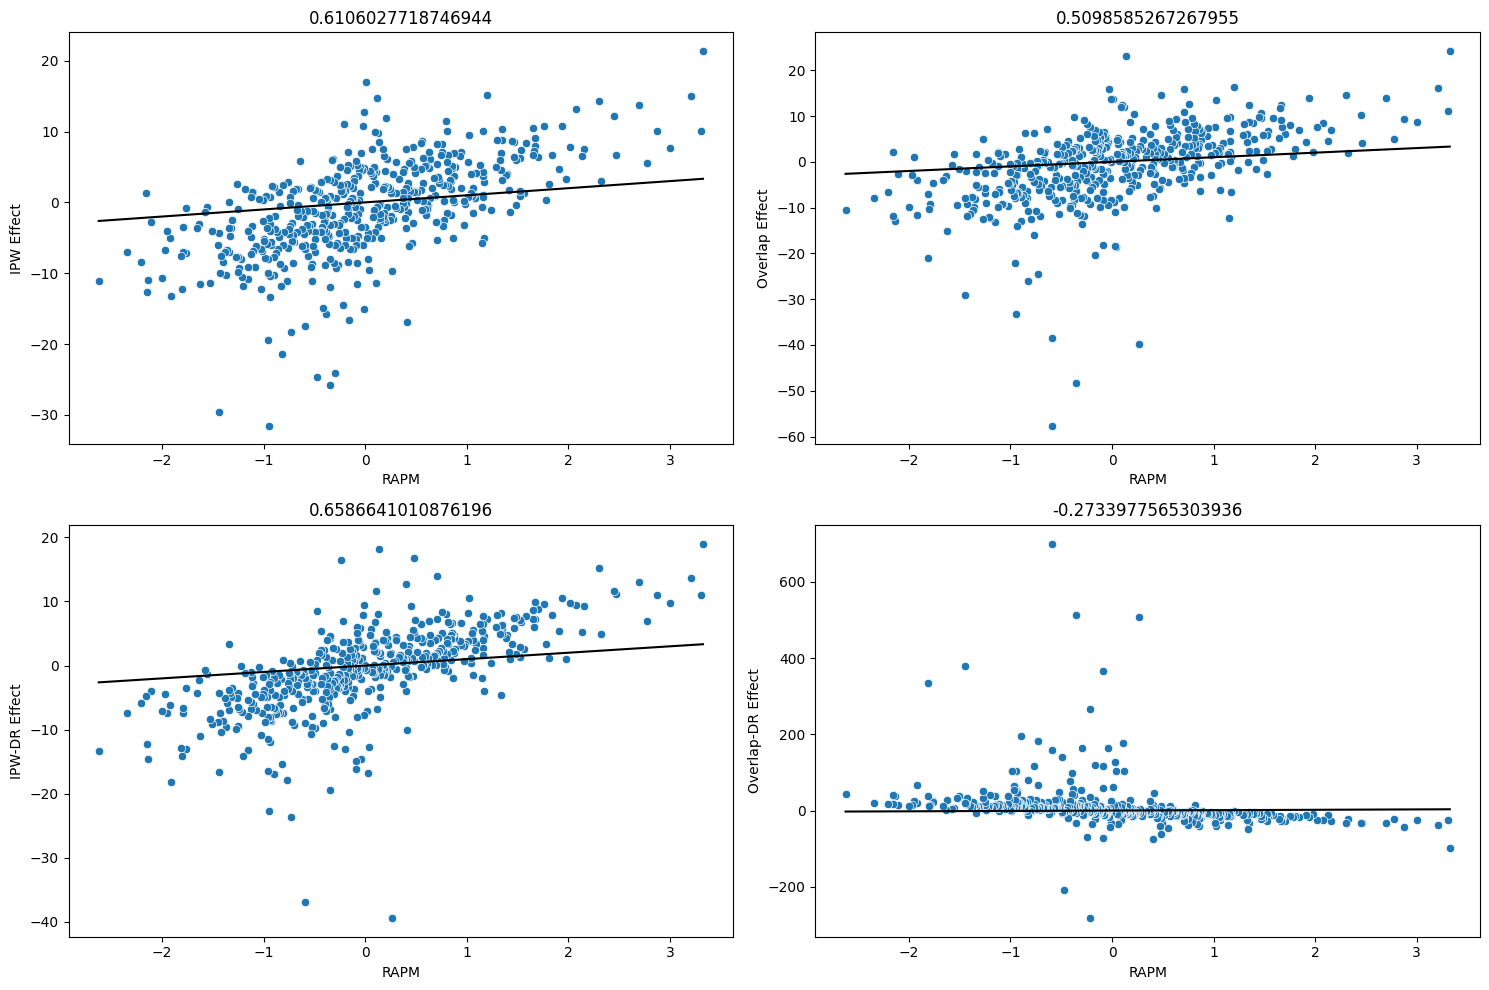

In [ ]:
bools = results['Minutes'] >= 48

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].plot()

sns.scatterplot(results[bools], x='RAPM', y='IPW Effect', ax=ax[0, 0]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'IPW Effect']))
ax[0, 0].plot(results.loc[bools, 'RAPM'], results.loc[bools, 'RAPM'], 'k-')
sns.scatterplot(results[bools], x='RAPM', y='Overlap Effect', ax=ax[0, 1]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'Overlap Effect']))
ax[0, 1].plot(results.loc[bools, 'RAPM'], results.loc[bools, 'RAPM'], 'k-')
sns.scatterplot(results[bools], x='RAPM', y='IPW-DR Effect', ax=ax[1, 0]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'IPW-DR Effect']))
ax[1, 0].plot(results.loc[bools, 'RAPM'], results.loc[bools, 'RAPM'], 'k-')
sns.scatterplot(results[bools], x='RAPM', y='Overlap-DR Effect', ax=ax[1, 1]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'Overlap-DR Effect']))
ax[1, 1].plot(results.loc[bools, 'RAPM'], results.loc[bools, 'RAPM'], 'k-')


fig.tight_layout()
fig.show()

In [ ]:
sns.scatterplot(results[bools], x='RAPM', y='Average Effect').set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'Average Effect']))

Text(0.5, 1.0, '0.6277813381865056')

In [ ]:
print(results['Average Effect'].corr(results['RAPM']))


0.47317244196482916


# Analyze Importance of Features

Here, we investigate the importance of the input features into both the PM model and propensity models.

We will compute each feature's SHAP values.

In [ ]:
# random forest
'''
n = 4

fig, ax = plt.subplots(n,n, figsize=(20, 15))
plr_ids = list(probs)

for k in range(n**2):
    i = k // n
    j = k % n

    plr_id              = plr_ids[k]
    plr_model, plr_data = prob_models[plr_id][0], get_features(prob_models[plr_id][1])
    
    subset      = shap.utils.sample(plr_data, int(np.ceil(0.1 * len(plr_data))), random_state=1234) # use 10% of data as a mask
    explainer   = shap.Explainer(plr_model.predict, subset)
    shap_values = explainer(plr_data)

    graph = shap.plots.bar(shap_values, ax=ax[i, j], show=False)
    graph.set_title(plr_id_to_name[plr_id])

fig.tight_layout()
fig.show()
'''

'\nn = 4\n\nfig, ax = plt.subplots(n,n, figsize=(20, 15))\nplr_ids = list(probs)\n\nfor k in range(n**2):\n    i = k // n\n    j = k % n\n\n    plr_id              = plr_ids[k]\n    plr_model, plr_data = prob_models[plr_id][0], get_features(prob_models[plr_id][1])\n    \n    subset      = shap.utils.sample(plr_data, int(np.ceil(0.1 * len(plr_data))), random_state=1234) # use 10% of data as a mask\n    explainer   = shap.Explainer(plr_model.predict, subset)\n    shap_values = explainer(plr_data)\n\n    graph = shap.plots.bar(shap_values, ax=ax[i, j], show=False)\n    graph.set_title(plr_id_to_name[plr_id])\n\nfig.tight_layout()\nfig.show()\n'

In [ ]:
# random forest
plr_ids = list(probs)

for k in range(2):

    plr_id              = plr_ids[k]
    plr_model, plr_data = prob_models[plr_id][0], get_features(prob_models[plr_id][1])
    
    time_fig, time_ax = shap.partial_dependence_plot(
        "team_strength",
        plr_model.predict,
        plr_data,
        model_expected_value=True, 
        feature_expected_value=True,
        show=False,
        ice=False
    )
    time_ax.set_title(plr_id_to_name[plr_id])
    time_fig.show()
    
    opp_fig, opp_ax = shap.plots.partial_dependence(
        "opponent_strength",
        plr_model.predict,
        plr_data,
        model_expected_value=True, 
        feature_expected_value=True,
        show=False,
        ice=False
    )
    opp_ax.set_title(plr_id_to_name[plr_id])
    opp_fig.show()
    
    margin_fig, margin_ax = shap.plots.partial_dependence(
        "start_score_margin",
        plr_model.predict,
        plr_data,
        model_expected_value=True, 
        feature_expected_value=True,
        show=False,
        ice=False
    )
    margin_ax.set_title(plr_id_to_name[plr_id])
    margin_fig.show()

TypeError: 'PlayerPropensityModel' object is not subscriptable

# Out-of-Sample Testing

We now compute the RMSE of our models, and compare it against the RAPM RMSE.

All data is from the 2023-2024 season.



In [ ]:
rapm_model = RidgeCV( # Leave-One-Out CV based on MSE
    alphas=[10, 50, 100, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000],
    fit_intercept=False
).fit(design, data['margin'], sample_weight=data['minutes'])

In [ ]:
oos_data: pd.DataFrame      = pd.read_csv('../../design_matrices/nba_2324_season_rapm_data.csv.gz', dtype={'game_id': str})
oos_players: dict[str, str] = pd.read_csv('../../data/nba_2324_player_table.csv', index_col='player_id', dtype={'player_id': str})['player_name'].to_dict()
oos_design                  = oos_data.drop(['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin'], axis=1)
oos_data                    = add_game_features(oos_data[['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin']])

combined_plrs = np.intersect1d(list(oos_players), list(plr_id_to_name))

In [ ]:
# filter out stints when the game is decided
# drop iff start_time_elapsed >= 36 AND |start_score_margin| >= 20
# keep iff start_time_elapsed < 36 OR |start_score_margin| < 20
oos_ok_stints = (oos_data['start_time_left'] < 36) | (oos_data['start_score_margin'].abs() < 20)
oos_data = oos_data.loc[oos_ok_stints]
oos_design = oos_design.loc[oos_ok_stints]

# filter out data with low minute players
low_min_plrs = list(set(get_low_min_plrs(box_scores)).intersection(combined_plrs))

has_low_min_plr = oos_design[low_min_plrs].abs().sum(axis=1).astype(bool)

oos_design = oos_design.loc[~has_low_min_plr]
oos_data = oos_data.loc[~has_low_min_plr]

# filter out stints that contain new players
missing_from_2324 = list(set(plr_id_to_name) - set(combined_plrs))
missing_from_2223 = list(set(oos_players) - set(combined_plrs))
has_missing_player: pd.Series = oos_design[missing_from_2223].abs().sum(axis=1).astype(bool)

oos_design  = oos_design.loc[~has_missing_player].drop(missing_from_2223, axis=1)
oos_data    = oos_data.loc[~has_missing_player]

# add in players missing from 23/24 (they're just all zeros)
oos_design[missing_from_2324] = pd.DataFrame(
    data=np.zeros((len(oos_design.index), len(missing_from_2324)), dtype=np.int64),
    index=oos_design.index
)

# reorder the columns so the ordering matches the ordering of the 22/23 data
oos_design = oos_design[design.columns]

oos_design

201939  202691  203110  203952  1626172  1629673  203210  1630164  \
0           0       0       0       0        0        0       0        0   
1           0       0       0       0        0        0       0        0   
2           0       0       0       0        0        0       0        0   
3           0       0       0       0        0        0       0        0   
4           0       0       0       0        0        0       0        0   
...       ...     ...     ...     ...      ...      ...     ...      ...   
31787       0       0       0       0        0        0       0        0   
31809       0       0       0       0        0        0       0        0   
31832       0       0       0       0        0        0       0        0   
31842       0       0       0       0        0        0       0        0   
31860       0       0       0       0        0        0       0        0   

       1630228  1628978  1630541  1631157  201143  203935  1627759  1628369  \
0            0        0        0        0       0       0        0        0   
1            0        0        0        0       0       0        0        0   
2            0        0        0        0       0       0        0        0   
3            0        0        0        0       0       0        0        0   
4            0        0        0        0       0       0        0        0   
...        ...      ...      ...      ...     ...     ...      ...      ...   
31787        0        0        0        0       0       0        0        0   
31809        0        0        0        0       0       0        0        0   
31832        0        0        0        0       0       0        0        0   
31842        0        0        0        0       0       0        0        0   
31860        0        0        0        0       0       0        0        0   

       1628401  203943  1629684  1627763  201933  1630573  203084  1627734  \
0            0       0        0        0       0        0       0        0   
1            0       0        0        0       0        0       0        0   
2            0       0        0        0       0        0       0        0   
3            0       0        0        0       0        0       0        0   
4            0       0        0        0       0        0       0        0   
...        ...     ...      ...      ...     ...      ...     ...      ...   
31787        0       0        0        0       0        0       0        0   
31809        0       0        0        0       0        0       0        0   
31832        0       0        0        0       0        0       0        0   
31842        0       0        0        0       0        1       0        0   
31860        0       0        0        0       0        0       0        0   

       1628368  1628989  1629644  1628370  1629056  1630558  1626158  1626168  \
0            0        0        0        0        0        0        0        0   
1            0        0        0        0        0        0        0        0   
2            0        0        0        0        0        0        0        0   
3            0        0        0        0        0        0        0        0   
4            0        0        0        0        0        0        0        0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
31787        0        0        0        0        0        0        0        0   
31809        0        0        0        0        0        0        0        0   
31832        0        0        0        0        0        0        0        0   
31842        0        0        0        0        0        0        0        0   
31860        0        0        0        0        0        0        0        0   

       202711  1630180  1630191  1630595  1631093  1630165  1631105  1628995  \
0           0        0        0        0        0        0        0        0   
1           0        0        0        0        0        0        0        

Now we write a function that will compute the RMSEs for a given player

## Evaluation over Players who Switched Teams

These players are of primary interest, since their environment is the one that changed the most.

In [ ]:
team_data_2223: pd.DataFrame = CommonAllPlayers(season='2022', is_only_current_season=0).get_data_frames()[0].astype({'PERSON_ID': str}).set_index('PERSON_ID', drop=True)
team_data_2324: pd.DataFrame = CommonAllPlayers(season='2023', is_only_current_season=0).get_data_frames()[0].astype({'PERSON_ID': str}).set_index('PERSON_ID', drop=True)

diff_team_bools = team_data_2223.loc[combined_plrs, 'TEAM_ID'] != team_data_2324.loc[combined_plrs, 'TEAM_ID']

plrs_on_diff_team: pd.Index = team_data_2223.loc[combined_plrs][diff_team_bools].index

# some players aren't present in any stints (they were added before filtering). 
# filter them out because computing their RMSE doesn't make sense

valid_plrs = pd.Index(plr for plr in plrs_on_diff_team if oos_design[plr].any())

valid_plrs

Index(['101108', '1626145', '1626153', '1626158', '1626162', '1626166',
       '1626174', '1626179', '1626196', '1626220',
       ...
       '203552', '203915', '203925', '203926', '203933', '203935', '203967',
       '203994', '204001', '204060'],
      dtype='object', length=160)

In [ ]:
def compute_rmse(
    plr_id: str, 
    *, 
    oos_data: pd.DataFrame = oos_data, 
    oos_design: pd.DataFrame = oos_design, 
    coefs: pd.DataFrame = results
) -> list[float]:
    '''
    Compute a player's RMSE metrics. In order: `(plr_name, num_of_stints, rapm, ipw, overlap, ipw_dr, overlap_dr)`.
    This is intended to be used for the creation of a dataset.

    This evaluates each of the coefficients against stints the player
    was present in.
    '''
    plr_in_stint: list[bool]        = oos_design[plr_id] != 0
    plr_true_target: pd.DataFrame   = oos_data.loc[plr_in_stint, 'margin']
    plr_design: pd.DataFrame        = oos_design.loc[plr_in_stint]

    rapm_coefs          = coefs.loc[plr_design.columns, 'RAPM']
    ipw_coefs           = coefs.loc[plr_design.columns, 'IPW Effect']
    overlap_coefs       = coefs.loc[plr_design.columns, 'Overlap Effect']
    ipw_dr_coefs        = coefs.loc[plr_design.columns, 'IPW-DR Effect']
    overlap_dr_coefs    = coefs.loc[plr_design.columns, 'Overlap-DR Effect']

    return [
        plr_id_to_name[plr_id],
        len(plr_design),
        round(rmse(plr_true_target, plr_design @ rapm_coefs)        , 2),
        round(rmse(plr_true_target, plr_design @ ipw_coefs)         , 2),
        round(rmse(plr_true_target, plr_design @ overlap_coefs)     , 2),
        round(rmse(plr_true_target, plr_design @ ipw_dr_coefs)      , 2),
        round(rmse(plr_true_target, plr_design @ overlap_dr_coefs)  , 2)
    ]

In [ ]:
rmse_results = pd.DataFrame(
    data=[compute_rmse(plr) for plr in valid_plrs],
    index=valid_plrs,
    columns=['Player', 'Stints', 'RAPM RMSE', 'IPW RMSE', 'Overlap RMSE', 'IPW-DR RMSE', 'Overlap-DR RMSE']
)

rmse_results['Best'] = rmse_results[['RAPM RMSE', 'IPW RMSE', 'Overlap RMSE', 'IPW-DR RMSE', 'Overlap-DR RMSE']].idxmin(axis=1)

In [ ]:
rmse_results.sort_values(by='Stints', ascending=False).to_csv('../../results/player_rmse.csv')

In [ ]:
results

Unnamed: 0         Player Name      RAPM  Average Effect  \
Player ID                                                             
203999            274        Nikola Jokic  3.325439        0.529107   
203110              2      Draymond Green  3.308574        0.288675   
203954            156         Joel Embiid  3.211865        0.373349   
201950            259        Jrue Holiday  3.001383        0.306525   
202695            306       Kawhi Leonard  2.876934        0.229572   
...               ...                 ...       ...             ...   
1630197           331  Aleksej Pokusevski -2.152207       -0.381854   
1629022           168    Lonnie Walker IV -2.153609       -0.241357   
1630170            44       Devin Vassell -2.202961       -0.240975   
1631093            36          Jaden Ivey -2.342345       -0.294087   
1631323           130   Simone Fontecchio -2.623610       -0.331522   

           IPW Effect  Overlap Effect  IPW-DR Effect  Overlap-DR Effect  \
Player ID                                                                 
203999      21.177795       22.165526      22.237305        -171.938771   
203110      10.065428       11.219964      12.815739         -37.782696   
203954      15.347206       16.365062      16.401038         -73.072575   
201950       7.873574        8.831281       9.655673         -26.547628   
202695       9.768150        7.362730      11.925928         -75.936005   
...               ...             ...            ...                ...   
1630197    -12.523209      -11.125160     -13.894384          56.614960   
1629022      1.108845        1.354028      -2.347229         -11.501636   
1630170     -8.469290       -6.341627      -5.918231          34.568174   
1631093     -7.020723       -7.155381      -7.611715          26.884577   
1631323    -11.131764      -11.751322     -11.206460          43.720087   

           Minutes  
Player ID           
203999     2251.50  
203110     2012.04  
203954     2243.46  
201950     2093.08  
202695     1817.22  
...            ...  
1630197     700.25  
1629022    1199.52  
1630170    1116.12  
1631093    2079.10  
1631323     740.51  

[539 rows x 9 columns]

In [ ]:
rmse_results

Player  Stints  RAPM RMSE  IPW RMSE  Overlap RMSE  \
101108           Chris Paul     228      74.20     75.81         75.09   
1626145          Tyus Jones     306      60.19     63.32         64.21   
1626153        Delon Wright      67      61.09     63.56         63.47   
1626158      Richaun Holmes     118      62.89     64.43         65.53   
1626162     Kelly Oubre Jr.     598      70.81     72.60         73.38   
...                     ...     ...        ...       ...           ...   
203935         Marcus Smart     246      75.06     78.65         78.66   
203967          Dario Saric     141      68.78     69.62         69.31   
203994         Jusuf Nurkic     644      67.99     69.94         70.34   
204001   Kristaps Porzingis     520      62.71     64.82         64.74   
204060           Joe Ingles     304      68.83     71.00         69.81   

         IPW-DR RMSE  Overlap-DR RMSE       Best  
101108         76.54           115.15  RAPM RMSE  
1626145        64.43           116.33  RAPM RMSE  
1626153        62.11            98.89  RAPM RMSE  
1626158        66.07           233.42  RAPM RMSE  
1626162        72.93           129.91  RAPM RMSE  
...              ...              ...        ...  
203935         79.07           148.93  RAPM RMSE  
203967         69.86           115.17  RAPM RMSE  
203994         71.38           177.90  RAPM RMSE  
204001         65.04           152.16  RAPM RMSE  
204060         70.70           180.66  RAPM RMSE  

[160 rows x 8 columns]

# Compare 2023 Metrics to 2023-2024 Box Score Stats

In [ ]:
box_stats_2324 = pd.read_csv('../../data/nba_2324_box_stats.csv')
oos_name_to_id = dict((plr_name, plr_id) for plr_id, plr_name in oos_players.items())

box_stats_2324['Player']   = box_stats_2324['Player'].apply(strip_accents)
box_stats_2324['PlayerID'] = box_stats_2324['Player'].apply(lambda name: oos_name_to_id[name])
box_stats_2324.drop_duplicates('Player', keep='first', inplace=True)

box_stats_2324.set_index('PlayerID', inplace=True)

In [ ]:
results.loc[valid_plrs]


Player Name      RAPM  Average Effect  IPW Effect  \
101108           Chris Paul  0.873268        0.046885    7.315851   
1626145          Tyus Jones  0.149894       -0.025198   -1.995159   
1626153        Delon Wright  1.237475        0.076923   -1.279695   
1626158      Richaun Holmes -1.272301       -0.205286   -7.254008   
1626162     Kelly Oubre Jr. -0.496374       -0.105426   -4.775400   
...                     ...       ...             ...         ...   
203935         Marcus Smart  0.148054        0.058163   -0.731642   
203967          Dario Saric  0.174548        0.082508    7.732897   
203994         Jusuf Nurkic  0.635900        0.098221    6.302923   
204001   Kristaps Porzingis  1.333455        0.114583    4.740172   
204060           Joe Ingles -0.740537       -0.051724   -0.268395   

         Overlap Effect  IPW-DR Effect  Overlap-DR Effect  Minutes  
101108         6.720978       7.113147         -42.100289  1730.94  
1626145       -3.761316      -4.356659          10.449970  1908.24  
1626153       -2.941722      -1.401675           6.616154  1218.90  
1626158      -12.605820     -11.246705          43.118745   326.23  
1626162       -5.705598      -0.272027          16.755345  1403.06  
...                 ...            ...                ...      ...  
203935        -2.870498      -2.852956          -0.928356  1957.03  
203967         9.171690       6.934881         -40.582184   713.89  
203994         5.394604       6.930483         -25.951034  1119.27  
204001         7.117935      12.201815         -42.981183  2000.91  
204060        -1.090643      -1.632902          -1.444447  1177.84  

[160 rows x 8 columns]

In [ ]:
axis = sns.scatterplot(x=results.loc[valid_plrs, 'RAPM'], y=box_stats_2324.loc[valid_plrs, 'BPM'])
axis.set_title(results.loc[valid_plrs, 'RAPM'].corr(box_stats_2324.loc[valid_plrs, 'BPM']))
axis.plot(results.loc[valid_plrs, 'RAPM'], results.loc[valid_plrs, 'RAPM'], 'k-')